In [1]:
import numpy as np
from keras.layers import Input, Dense, Lambda, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import json
from collections import Counter
from io import BytesIO
import PIL
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [2]:
batch_size = 250 # batch size

def augment(icons, labels, size):
    aug_icons = []
    aug_labels = []
    for icon, label in zip(icons, labels):
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                aug_labels.append(label)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
            if flip % 2 == 0:
                icon = np.flipud(icon)
    aug_icons = np.asarray(aug_icons) / 255

    return aug_icons, np.asarray(aug_labels)

def load_icons(train_size=0.90, size=28):
    icon_index = json.load(open('icons/index.json'))
    cat_count = Counter(icon['category'] for icon in icon_index)
    cats = [cat for cat, count in cat_count.items() if count > 50]
    cat_to_index = {cat: idx for idx, cat in enumerate(cats)}
    x = []
    y = []
    img_rows, img_cols = size, size
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        cat_idx = cat_to_index.get(icon['category'])
        if cat_idx is None:
            continue
        img_path = 'icons/png%d/%s.png' % (size, icon['name'])
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
        y.append(cat_idx)
    target_size = len(x) - (len(x) % batch_size)
    x = x[:target_size]
    y = y[:target_size]
    x = np.asarray(x)
    y = np.asarray(y)
    train_size = int(train_size * x.shape[0])
    train_size -= train_size % batch_size
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    x_train, y_train = augment(x_train, y_train, size=size)
    x_test, y_test = augment(x_test, y_test, size=size)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_icons(size=32)
x_train.shape

(64000, 32, 32, 1)

In [3]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [4]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, num_pixels, 1))
    channels = 4
    x = pixels
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x) 
    x = Flatten()(x)
    encoder_hidden = Dense(latent_space_depth, name='encoder_hidden')(x)

    z_mean = Dense(latent_space_depth, activation='linear', name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear', name='z_log_var')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    up_samp0 = UpSampling2D((2, 2))
    up_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    up_samp1 = UpSampling2D((2, 2))
    up_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
    up_samp2 = UpSampling2D((2, 2))
    up_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    up_samp3 = UpSampling2D((2, 2))
    up_conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')
    up_samp4 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    decoder_in = Input(shape=(latent_space_depth,))
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    d_x = up_samp0(d_x)
    d_x = up_conv1(d_x)
    d_x = up_samp1(d_x)
    d_x = up_conv2(d_x)
    d_x = up_samp2(d_x)
    d_x = up_conv3(d_x)
    d_x = up_samp3(d_x)
    d_x = up_conv4(d_x)
    d_x = up_samp4(d_x)
    decoder_out= decoded(d_x)

    decoder = Model(decoder_in, decoder_out)    

    a_x = Reshape((1, 1, latent_space_depth))(z)
    a_x = up_samp0(a_x)
    a_x = up_conv1(a_x)
    a_x = up_samp1(a_x)
    a_x = up_conv2(a_x)
    a_x = up_samp2(a_x)
    a_x = up_conv3(a_x)
    a_x = up_samp3(a_x)
    a_x = up_conv4(a_x)
    a_x = up_samp4(a_x)
    outputs= decoded(a_x)
    
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64000, 32, 32, 1), (64000,), (8000, 32, 32, 1), (8000,))

In [6]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 64000 samples, validate on 8000 samples
Epoch 1/100
64000/64000 [==============================] - 4s - loss: 1212.1122 - KL_loss: 20.6414 - reconstruction_loss: 1191.4710 - val_loss: 1161.1961 - val_KL_loss: 4.8197 - val_reconstruction_loss: 1156.3765
Epoch 2/100
64000/64000 [==============================] - 2s - loss: 1105.1602 - KL_loss: 3.8504 - reconstruction_loss: 1101.3100 - val_loss: 1158.4499 - val_KL_loss: 3.0356 - val_reconstruction_loss: 1155.4144
Epoch 3/100
64000/64000 [==============================] - 2s - loss: 1103.0512 - KL_loss: 2.1487 - reconstruction_loss: 1100.9027 - val_loss: 1156.6166 - val_KL_loss: 1.2929 - val_reconstruction_loss: 1155.3238
Epoch 4/100
64000/64000 [==============================] - 2s - loss: 1101.1944 - KL_loss: 0.6015 - reconstruction_loss: 1100.5930 - val_loss: 1154.9528 - val_KL_loss: 0.1220 - val_reconstruction_loss: 1154.8309
Epoch 5/100
64000/64000 [==============================] - 2s - loss: 1100.2532 - KL_loss: 0.0442 - re

64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 9.9250e-07 - reconstruction_loss: 1100.0487 - val_loss: 1154.5304 - val_KL_loss: 1.0638e-06 - val_reconstruction_loss: 1154.5305
Epoch 39/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 4.7101e-07 - reconstruction_loss: 1100.0487 - val_loss: 1154.5304 - val_KL_loss: 1.0364e-06 - val_reconstruction_loss: 1154.5305
Epoch 40/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 4.2908e-07 - reconstruction_loss: 1100.0486 - val_loss: 1154.5304 - val_KL_loss: 1.1915e-06 - val_reconstruction_loss: 1154.5305
Epoch 41/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 4.5451e-07 - reconstruction_loss: 1100.0486 - val_loss: 1154.5304 - val_KL_loss: 1.2732e-06 - val_reconstruction_loss: 1154.5305
Epoch 42/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 4.0155e-07 - reconstruction_loss: 110

64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 9.4354e-07 - reconstruction_loss: 1100.0486 - val_loss: 1154.5304 - val_KL_loss: 8.4663e-07 - val_reconstruction_loss: 1154.5305
Epoch 76/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 8.7390e-07 - reconstruction_loss: 1100.0486 - val_loss: 1154.5304 - val_KL_loss: 5.7038e-07 - val_reconstruction_loss: 1154.5305
Epoch 77/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 1.0695e-06 - reconstruction_loss: 1100.0486 - val_loss: 1154.5304 - val_KL_loss: 5.1215e-07 - val_reconstruction_loss: 1154.5305
Epoch 78/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 7.6753e-07 - reconstruction_loss: 1100.0486 - val_loss: 1154.5303 - val_KL_loss: 1.3057e-06 - val_reconstruction_loss: 1154.5305
Epoch 79/100
64000/64000 [==============================] - 2s - loss: 1100.0485 - KL_loss: 9.0394e-07 - reconstruction_loss: 110

In [7]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
print(random_number)

[[-1.01018345  0.14576579  0.18390991  0.34320054 -0.36556602  1.32960782
  -0.19938605  0.46906693  1.22190387  0.50300721 -0.64098564 -0.73783789
   0.58557924  0.7134851   0.71286698  1.61034166  0.36436339  0.09407381
   0.32464917 -0.48542367  1.65637044  0.38964642  1.74499037 -0.45251862
   0.73056008 -1.89925773  1.24434079  0.91100458  0.54002933  1.05488974
  -0.59346558  0.35361308 -0.98555952  2.78201053 -0.66912622  1.06631948
   1.54922479  0.1241674   0.55068832 -2.13417169  1.19913858 -1.11051027
  -0.22918096 -0.07209896  1.35254944 -1.67653139 -0.02943975 -0.94943157
   1.60725357 -0.22673023 -0.73291677  1.13594455  0.38643106 -1.80983994
  -2.00330142 -2.27870728  0.9662353   0.31059454  0.31622532  0.6696451
  -0.56017409 -1.63275559 -0.38467523  0.4806943   0.75473305 -1.11361478
  -0.66036052 -1.15647855 -0.02320854  2.0410689   0.15381506  0.87477253
   0.53839441  0.45211456  0.69039436  0.77761039  1.01776532  0.29626284
  -0.27930746  0.94264467 -1.33799681 -

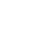

In [8]:
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


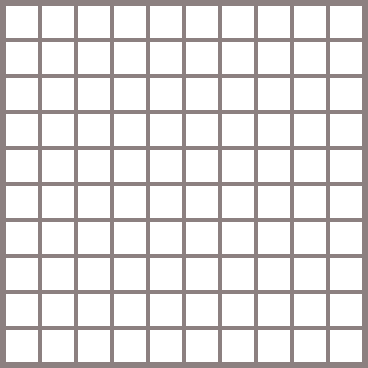

In [9]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

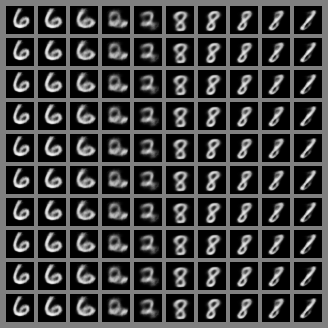

In [20]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[: 1] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
#        vec[: 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [47]:
vec.shape

(1, 2)